In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import re
from scipy.sparse import csr_matrix
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

### Linear Regression

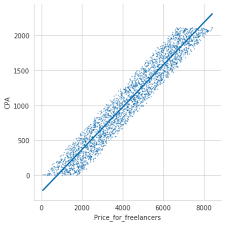

### Gradient boosting


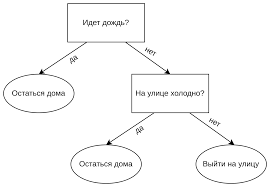

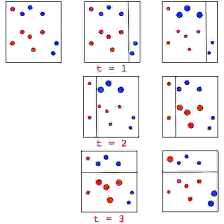

### Neural network


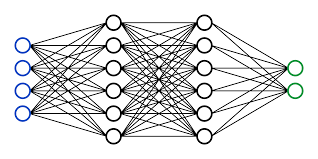

### Read Data

In [ ]:
# https://www.kaggle.com/competitions/cu-minihack-whats-ages/data
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
train_users = pd.read_csv('train_users.csv')
test_users = pd.read_csv('test_users.csv')

movies['Genres'] = [s.split('|') for s in movies['Genres']]

In [ ]:
ltr = len(train_users)
data = pd.concat([train_users, test_users]).reset_index(drop = True)

### Create user - film matrix

In [ ]:
user_film = csr_matrix((np.ones(len(ratings)),(ratings['UserID'].values,ratings['MovieID'].values)),
                      shape=(ratings['UserID'].max() + 1, ratings['MovieID'].max() + 1))

user_user = user_film * user_film.T
film_film = user_film.T * user_film

### OHE for compute statistics

In [ ]:
all_type_genres = [i for s in movies['Genres'] for i in s]
all_type_genres = sorted(set(all_type_genres))
all_type_genres_dict = {x:i for i,x in enumerate(all_type_genres)}

ratings['Genres'] = ratings['MovieID'].map(movies['Genres'])
ratings['Genres'] = [[all_type_genres_dict[g] for g in g_list] for g_list in ratings['Genres'] ]

for i in (range(len(all_type_genres_dict))):
    ratings[f'Genres_{i}'] = [1 if i in g else 0 for g in ratings['Genres']]

### Value counts by genre, year and film clusters

In [ ]:
data['count'] = data['UserID'].map( ratings['UserID'].value_counts() )
for i in (range(len(all_type_genres_dict))):
    data[f'count_genre_{i}'] = (data['UserID'].map( ratings[ratings[f'Genres_{i}'] == 1]['UserID'].value_counts() ) / data['count']).fillna(0)

count_genre_array = data[[col for col in data.columns if 'count_genre_' in col]].values

In [ ]:
movies['year'] = [int(re.findall('\(\d+\)', x)[0][1:-1]) for x in movies['Title']]
movies['year_round'] = movies['year']
movies.loc[movies['year'] < 1993, 'year_round'] = (movies.loc[movies['year'] < 1993, 'year_round'] // 5) * 5
# movies['year_round'].hist(bins = 100)
ratings['year'] = ratings['MovieID'].map(movies.set_index('MovieID')['year_round'])

for year in (ratings['year'].unique()):
    data[f'count_year_{year}'] = (data['UserID'].map( ratings[ratings['year'] == year]['UserID'].value_counts() ) / data['count']).fillna(0)
count_year_array = data[[col for col in data.columns if 'count_year_' in col]].values

In [ ]:
km = KMeans(n_clusters = 15, random_state = 228)
clusters = km.fit_predict(np.array(film_film.toarray() ))

ratings['cluster'] = 0
for i in range(15):
    inds = np.where(clusters == i)[0]
    ratings.loc[ratings['MovieID'].isin(inds), 'cluster'] = i

for year in (ratings['cluster'].unique()):
    data[f'count_cluster_{year}'] = (data['UserID'].map( ratings[ratings['cluster'] == year]['UserID'].value_counts() ) / data['count']).fillna(0)
count_cluster_array = data[[col for col in data.columns if 'count_cluster_' in col]].values

In [ ]:
km = KMeans(n_clusters = 15, random_state = 228, max_iter = 100)
clusters = km.fit_predict(user_user.toarray())

data['cluster'] = 0
for i in range(15):
    inds = np.where(clusters == i)[0]
    data.loc[data['UserID'].isin(inds), 'cluster'] = i

for i in range(data['cluster'].unique().shape[0]):
    data[f'User_cluster_{i}'] = (data['cluster'] == i).astype('int')
count_user_cluster_array = data[[col for col in data.columns if 'User_cluster_' in col]].values

### Occupation OHE

In [ ]:
for i in range(data['Occupation'].unique().shape[0]):
    data[f'Occupation_{i}'] = (data['Occupation'] == i).astype('int')

occupation_array = data[[col for col in data.columns if 'Occupation_' in col]].values

### Validation

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 322)
split_list = [x for x in skf.split(data.loc[:ltr-1], data.loc[:ltr-1, 'Age'])]

### Linear regression prediction

### Check Linear Regression parameters

**1. normalize data**

**2. alpha**

In [ ]:
tocsr_index = data['UserID'].sort_values().index

lr_data_1 = np.concatenate([user_film.toarray(), count_genre_array[tocsr_index], count_year_array[tocsr_index],
                         occupation_array[tocsr_index], count_cluster_array[tocsr_index], count_user_cluster_array[tocsr_index]], 1)
lr_data_2 = np.concatenate([count_genre_array[tocsr_index], count_year_array[tocsr_index],
                         occupation_array[tocsr_index], count_cluster_array[tocsr_index], count_user_cluster_array[tocsr_index]], 1)
lr_data_3 = np.concatenate([user_film.toarray()], 1)

list_lr_data = [lr_data_1, lr_data_2, lr_data_3]
alpha_list = [250, 1, 500]
name_col_list = ['full_predict_lr', 'notuser_predict_lr', 'user_predict_lr']

for name_col, alpha, lr_data in zip(name_col_list, alpha_list, list_lr_data):
    predict_lr = np.zeros(len(data))
    sc_list = []
    for train_index, val_index  in split_list:
        train_index_tmp = data.loc[train_index, 'UserID'].values
        val_index_tmp = data.loc[val_index, 'UserID'].values
        test_index_tmp = data.loc[ltr:, 'UserID'].values

        X_train = lr_data[train_index_tmp]
        X_val = lr_data[val_index_tmp]
        X_test = lr_data[test_index_tmp]

        y_train = data.loc[train_index, 'Age'].values
        y_val = data.loc[val_index, 'Age'].values

        lr = Ridge(alpha = alpha, fit_intercept = True)
        lr.fit(X_train, y_train)

#         list_lr += [lr]
        predict_lr[val_index] = lr.predict(X_val)
        predict_lr[ltr:] += lr.predict(X_test) / len(split_list)
        sc = mean_squared_error(y_val, predict_lr[val_index])
        sc_list += [sc]
    print(name_col, np.mean(sc))

    data[name_col] = predict_lr

full_predict_lr 73.54915740938804
notuser_predict_lr 80.96613681031195
user_predict_lr 82.0595102143436


### Intresting *films*

In [ ]:
tmpq = []
# adds =
vc = ratings['MovieID'].value_counts()
vc = vc[vc > 100]
print(len(vc))
for k in (vc.index):
    l = ratings[ratings['MovieID'] == k]['UserID'].unique()
    s = data[data['UserID'].isin(l)]['Age'].std()
    m = data[data['UserID'].isin(l)]['Age'].mean()
    if m < data['Age'].mean() - 2.5 or m > data['Age'].mean() + 2.5:
        tmpq += [(s, m , k)]

1981


In [ ]:
strange_films = [x[2] for x in tmpq ]
len(strange_films)

1099

In [ ]:
for f in strange_films:
    uniq = ratings[ratings['MovieID'] == f]['UserID'].unique()
    data[f'{f}_flm'] = data['UserID'].isin(uniq).astype('int')

In [ ]:
# data  = data.drop([x for x in data.columns if '_flm' in x], axis = 1)

### Target mean

In [ ]:
for col in ['Occupation', 'cluster']:
    target_mean = np.zeros(len(data))
    for train_index, test_index in split_list:
        tmp_target_mean = data.loc[train_index].groupby('Occupation')['Age'].mean()
        target_mean[test_index] = data.loc[test_index, 'Occupation'].map(tmp_target_mean).values
        target_mean[ltr:] += ( data.loc[ltr:, 'Occupation'].map(tmp_target_mean) / len(split_list) )
    data[f'target_mean_{col}'] = target_mean

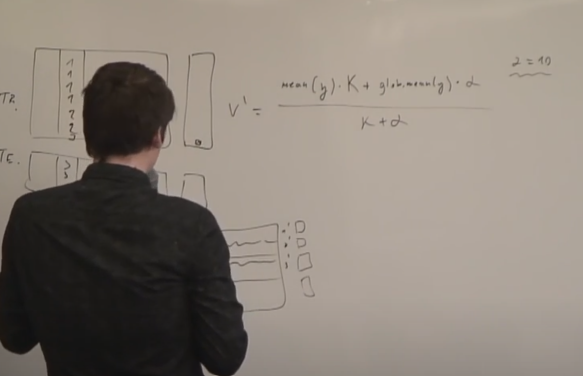

In [ ]:
alpha = 100
for col in ['Occupation', 'cluster']:
    target_mean = np.zeros(len(data))
    for train_index, test_index in split_list:
        tmp_target_mean = (data.loc[train_index].groupby('Occupation')['Age'].mean() * data.loc[train_index]['Occupation'].value_counts() +
                 data.loc[train_index, 'Age'].mean() + alpha) / data.loc[train_index]['Occupation'].value_counts()
        target_mean[test_index] = data.loc[test_index, 'Occupation'].map(tmp_target_mean).values
        target_mean[ltr:] += ( data.loc[ltr:, 'Occupation'].map(tmp_target_mean) / len(split_list) )
    data[f'target_stas_mean_{col}'] = target_mean

In [ ]:
# for k in ratings['MovieID'].value_counts()[:300]:
#     for train_index, test_index in split_list:
#         tmp_rat = ratings[ratings['UserID'].isin(data.loc[train_index, 'UserID'].values)]
#         tmp_rat = tmp_rat[tmp_rat.MovieID == k]
#         check_users = data.loc[data['UserID'].isin(tmp_rat['UserID'].unique())]['Age'].mean()
# #

### Similarity

In [ ]:
user_user_args = np.argsort(user_user.toarray(), 1)[:, ::-1][:, 1:]

In [ ]:
NUM_BEST_MAN = 100
closes_mans = [0] * (ratings['UserID'].max() + 1)
for train_index, test_index in split_list:
    train_index = data.loc[train_index, 'UserID'].values
    test_index = data.loc[test_index, 'UserID'].values

    set_train_index = set(train_index)
    for i in (list(test_index)):
        closes_mans[i] = list(set(user_user_args[i, :NUM_BEST_MAN].tolist()) & set(train_index))

train_index, test_index  = data.loc[:ltr-1, 'UserID'], data.loc[ltr:, 'UserID']
for i in (list(test_index)):
    closes_mans[i] = list(set(user_user_args[i, :NUM_BEST_MAN].tolist()) & set(train_index))

data['User_user'] = [ data.loc[data['UserID'].isin(x), 'Age'].mean() for x in closes_mans]

In [ ]:
# mean_squared_error(data.loc[:ltr - 1, 'Age'], data.loc[:ltr - 1, 'User_user'].fillna(data['Age'].mean()))

### Constant prediction

In [ ]:
mean_squared_error(data.loc[:ltr - 1, 'Age'], np.zeros(ltr) + data['Age'][:ltr].mean())

136.7415118923997

### Train boosting

In [ ]:
# data.columns
drop_cols = ['UserID', 'Age', 'cluster', 'Occupation', 'User_user']
train_cols = [col for col in data.columns if col not in drop_cols ]
len(train_cols)

1200

### Check LightGBM parameters

**1. num_leaves**

**2. lambda_l2, lambda_l1**

**3. extra_trees**

**4. min_data_in_leaf**

**5. feature_fraction, bagging_fraction , bagging_freq**

**6. dart, linear_tree**

**7. reg_sqrt , scale_pos_weight , is_unbalance**

In [ ]:
param_lgb = {
    'objective':        'mse',
    'verbosity':        -1,
    'boosting_type':    'gbdt',
    'random_state':     42,
    'lambda_l2':        5,
    'learning_rate':    0.1,
    'num_leaves':       32,
    'extra_trees' : True,
    'metric' :        'mse',
}

In [ ]:
full_tr = lgb.Dataset(data[train_cols].values, data['Age'].values)
cv = lgb.cv(param_lgb, full_tr, 400, folds = split_list, callbacks = [lgb.early_stopping(50), lgb.log_evaluation(10)]  )
num_trees = np.argmin(cv['valid l2-mean']) + 1

predict_train = np.zeros(ltr)
predict_test = np.zeros(len(test_users))

bst_list = []
for train_index, test_index in split_list:
    tr = lgb.Dataset(data.loc[train_index, train_cols], data['Age'][train_index])
    te = lgb.Dataset(data.loc[test_index, train_cols], data['Age'][test_index], reference=tr)
    bst = lgb.train(param_lgb, tr, num_boost_round=num_trees)
    bst_list += [bst]

    predict_train[test_index] = bst.predict(data.loc[test_index, train_cols])
    predict_test += bst.predict(data.loc[ltr:, train_cols]) / len(split_list)

mean_squared_error(data.loc[:ltr - 1, 'Age'],predict_train)

Training until validation scores don't improve for 50 rounds
[10]	cv_agg's valid l2: 69.2021 + 2.87493
[20]	cv_agg's valid l2: 57.4814 + 2.95933
[30]	cv_agg's valid l2: 55.1697 + 2.81454
[40]	cv_agg's valid l2: 54.6437 + 2.80271
[50]	cv_agg's valid l2: 54.6211 + 2.94139
[60]	cv_agg's valid l2: 54.7248 + 2.97829
[70]	cv_agg's valid l2: 54.8416 + 2.92268
[80]	cv_agg's valid l2: 55.0117 + 2.83982
[90]	cv_agg's valid l2: 55.1044 + 2.70474
[100]	cv_agg's valid l2: 55.3025 + 2.90156
Early stopping, best iteration is:
[57]	cv_agg's valid l2: 54.5651 + 2.94074


54.75671799263055

In [ ]:
train_cols = [col for col in data.columns if col not in drop_cols ]
feat_imp = np.zeros(len(train_cols))
for k in range(len(split_list)):
    feat_imp += bst.feature_importance(importance_type = 'gain')
srt_cols = [int(x[1].split('_')[0]) for x in sorted(zip(feat_imp, train_cols))[::-1] if 'flm' in x[1]]
bad_cols = [f'{x}_flm' for x in srt_cols]

In [ ]:
sorted(zip(bst.feature_importance(importance_type = 'gain'), train_cols))[::-1] [:10]

[(796635.2707366943, 'full_predict_lr'),
 (495508.627532959, 'user_predict_lr'),
 (114801.08285522461, 'notuser_predict_lr'),
 (76575.38201904297, 'Occupation_4'),
 (50810.10334777832, 'Occupation_13'),
 (15970.26628112793, 'count_cluster_7'),
 (9362.380012512207, 'count_cluster_2'),
 (8471.645065307617, '3204_flm'),
 (8176.216003417969, '126_flm'),
 (7462.996978759766, '3187_flm')]

### Basic feature selection

In [ ]:
# data.columns
drop_cols = ['UserID', 'Age', 'cluster', 'Occupation', 'User_user']
train_cols = [col for col in data.columns if col not in drop_cols +  bad_cols[100:]]
len(train_cols)

201

In [ ]:
full_tr = lgb.Dataset(data[train_cols].values, data['Age'].values)
cv = lgb.cv(param_lgb, full_tr, 400, folds = split_list, callbacks = [lgb.early_stopping(50), lgb.log_evaluation(10)]  )
num_trees = np.argmin(cv['valid l2-mean']) + 1

predict_train = np.zeros(ltr)
predict_test = np.zeros(len(test_users))

bst_list = []
for train_index, test_index in split_list:
    tr = lgb.Dataset(data.loc[train_index, train_cols], data['Age'][train_index])
    te = lgb.Dataset(data.loc[test_index, train_cols], data['Age'][test_index], reference=tr)
    bst = lgb.train(param_lgb, tr, num_boost_round=num_trees)
    bst_list += [bst]

    predict_train[test_index] = bst.predict(data.loc[test_index, train_cols])
    predict_test += bst.predict(data.loc[ltr:, train_cols]) / len(split_list)

mean_squared_error(data.loc[:ltr - 1, 'Age'],predict_train)

Training until validation scores don't improve for 50 rounds
[10]	cv_agg's valid l2: 68.7934 + 3.00312
[20]	cv_agg's valid l2: 57.2489 + 3.58182
[30]	cv_agg's valid l2: 54.6534 + 3.70396
[40]	cv_agg's valid l2: 54.0043 + 3.98636
[50]	cv_agg's valid l2: 53.9073 + 3.94462
[60]	cv_agg's valid l2: 54.0429 + 4.11927
[70]	cv_agg's valid l2: 54.0447 + 4.14493
[80]	cv_agg's valid l2: 54.0829 + 4.04324
[90]	cv_agg's valid l2: 54.1722 + 4.06093
Early stopping, best iteration is:
[49]	cv_agg's valid l2: 53.8771 + 3.89681


53.284973534952734

### Normal feature selection

In [ ]:
new_data = data.copy()
score_dict = {}
for col in tqdm(train_cols):
    tmp_col = new_data[col].copy()
    new_data[col] = new_data[col].sample(frac = 1., random_state = 322).reset_index(drop = True)
    pred = np.zeros(ltr)
    for (_, test_index), bst in zip(split_list, bst_list):
        pred[test_index] = bst.predict(new_data.loc[test_index, train_cols])
    score_dict[col] = mean_squared_error(data.loc[:ltr - 1, 'Age'],pred)
    # if score_dict[col] < 53.69633481866755:
    #     print(col)
    new_data[col] = tmp_col

  0%|          | 0/201 [00:00<?, ?it/s]

In [ ]:
bad_cols_new = [col for col in score_dict if score_dict[col] < 53.3]
train_cols_new = [col for col in train_cols if col not in bad_cols_new]
full_tr = lgb.Dataset(data[train_cols_new].values, data['Age'].values)
cv = lgb.cv(param_lgb, full_tr, 400, folds = split_list, callbacks = [lgb.early_stopping(50), lgb.log_evaluation(10)]  )
num_trees = np.argmin(cv['valid l2-mean']) + 1

predict_train = np.zeros(ltr)
predict_test = np.zeros(len(test_users))

bst_list = []
for train_index, test_index in split_list:
    tr = lgb.Dataset(data.loc[train_index, train_cols_new], data['Age'][train_index])
    te = lgb.Dataset(data.loc[test_index, train_cols_new], data['Age'][test_index], reference=tr)
    bst = lgb.train(param_lgb, tr, num_boost_round=num_trees)
    bst_list += [bst]

    predict_train[test_index] = bst.predict(data.loc[test_index, train_cols_new])
    predict_test += bst.predict(data.loc[ltr:, train_cols_new]) / len(split_list)


predict_train_good = list(predict_train)
mean_squared_error(data.loc[:ltr - 1, 'Age'],predict_train)

Training until validation scores don't improve for 50 rounds
[10]	cv_agg's valid l2: 67.837 + 3.22419
[20]	cv_agg's valid l2: 56.2347 + 3.5857
[30]	cv_agg's valid l2: 53.7101 + 3.80435
[40]	cv_agg's valid l2: 52.8606 + 4.04956
[50]	cv_agg's valid l2: 52.6548 + 4.17994
[60]	cv_agg's valid l2: 52.6936 + 4.28641
[70]	cv_agg's valid l2: 52.6639 + 4.33009
[80]	cv_agg's valid l2: 52.683 + 4.20895
[90]	cv_agg's valid l2: 52.7822 + 4.24143
[100]	cv_agg's valid l2: 52.7581 + 4.25576
[110]	cv_agg's valid l2: 52.8754 + 4.26266
[120]	cv_agg's valid l2: 52.9022 + 4.34624
Early stopping, best iteration is:
[77]	cv_agg's valid l2: 52.6359 + 4.26572


52.46849688743429

### Change parameter EXTRA_TREES

In [ ]:
param_lgb = {
    'objective':        'mse',
    'verbosity':        -1,
    'boosting_type':    'gbdt',
    'random_state':     42,
    'lambda_l2':        5,
    'learning_rate':    0.1,
    'num_leaves':       32,
    'metric' :        'mse',
}

bad_cols_new = [col for col in score_dict if score_dict[col] < 53.3]
train_cols_new = [col for col in train_cols if col not in bad_cols_new]
full_tr = lgb.Dataset(data[train_cols_new].values, data['Age'].values)
cv = lgb.cv(param_lgb, full_tr, 400, folds = split_list, callbacks = [lgb.early_stopping(50), lgb.log_evaluation(10)]  )
num_trees = np.argmin(cv['valid l2-mean']) + 1

predict_train = np.zeros(ltr)
predict_test = np.zeros(len(test_users))

bst_list = []
for train_index, test_index in split_list:
    tr = lgb.Dataset(data.loc[train_index, train_cols_new], data['Age'][train_index])
    te = lgb.Dataset(data.loc[test_index, train_cols_new], data['Age'][test_index], reference=tr)
    bst = lgb.train(param_lgb, tr, num_boost_round=num_trees)
    bst_list += [bst]

    predict_train[test_index] = bst.predict(data.loc[test_index, train_cols_new])
    predict_test += bst.predict(data.loc[ltr:, train_cols_new]) / len(split_list)

mean_squared_error(data.loc[:ltr - 1, 'Age'],predict_train)

Training until validation scores don't improve for 50 rounds
[10]	cv_agg's valid l2: 67.3945 + 2.92052
[20]	cv_agg's valid l2: 57.1353 + 3.23624
[30]	cv_agg's valid l2: 55.2181 + 3.40374
[40]	cv_agg's valid l2: 54.7682 + 3.68077
[50]	cv_agg's valid l2: 54.7297 + 3.61689
[60]	cv_agg's valid l2: 54.7984 + 3.49311
[70]	cv_agg's valid l2: 54.9203 + 3.528
[80]	cv_agg's valid l2: 55.0195 + 3.41827
[90]	cv_agg's valid l2: 55.121 + 3.38729
Early stopping, best iteration is:
[44]	cv_agg's valid l2: 54.6655 + 3.65487


54.99520031863451

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


### Check Catboost parameters

**1. num_leaves, max_depth**

**2. grow_policy**

**3. lambda_l2**

**4. min_data_in_leaf**

**5. bagging_temperature, random_strength , subsample**

**6. border_count, subsample**

In [ ]:
import catboost

params_cat = {
    'loss_function' :'RMSE',
    'task_type' : 'CPU',
     'max_depth' : 6,
    'eval_metric' :'RMSE',
    'learning_rate' : 0.1,
#     'grow_policy' : 'Depthwise',
    'grow_policy' : 'SymmetricTree',
    'l2_leaf_reg' : 5,
#     'subsample' : 0.65,
    # 'min_data_in_leaf' : 60,
    # 'bootstrap_type' :  'Bayesian',
    # 'border_count' :  127,
    'random_strength' : 1,
    # 'bagging_temperature' : 2,
    'random_state' : 42 ,
}

# bad_cols_new = [col for col in score_dict if score_dict[col] < 53.3]
train_cols_new = [col for col in train_cols if col not in bad_cols_new]

predict_train = np.zeros(ltr)
predict_test = np.zeros(len(test_users))


for power in [1, 2]:
    bst_list = []
    for train_index, test_index in split_list:
        tr = catboost.Pool(data.loc[train_index, train_cols_new], (data['Age'][train_index]) ** (1/power))
        te = catboost.Pool(data.loc[test_index, train_cols_new], (data['Age'][test_index]) ** (1/power))
        bst = catboost.train(tr, params_cat, eval_set = te, iterations = 1200, early_stopping_rounds = 100, verbose = 200)

        # bst = lgb.train(param_lgb, tr, num_boost_round=num_trees)
        bst_list += [bst]

        predict_train[test_index] = bst.predict(data.loc[test_index, train_cols_new]) ** power
        predict_test += bst.predict(data.loc[ltr:, train_cols_new]) / len(split_list) ** power

    print('SCORE: ', mean_squared_error(data.loc[:ltr - 1, 'Age'],predict_train))

0:	learn: 11.1848403	test: 11.1289797	best: 11.1289797 (0)	total: 102ms	remaining: 2m 2s
200:	learn: 5.5173031	test: 6.9917287	best: 6.9890105 (187)	total: 6.63s	remaining: 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 6.975350385
bestIteration = 271

Shrink model to first 272 iterations.
0:	learn: 11.1381183	test: 11.1155255	best: 11.1155255 (0)	total: 119ms	remaining: 2m 22s
200:	learn: 5.4473593	test: 7.1827390	best: 7.1827390 (200)	total: 8.59s	remaining: 42.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7.161863759
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 11.1068925	test: 11.1265261	best: 11.1265261 (0)	total: 27.3ms	remaining: 32.8s
200:	learn: 5.4020653	test: 7.5150013	best: 7.5022458 (161)	total: 9.89s	remaining: 49.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7.488896808
bestIteration = 246

Shrink model to first 247 iterations.
0:	learn: 11.1317337	test: 11.1533386	best: 11.15

In [ ]:
print('SCORE: ', mean_squared_error(data.loc[:ltr - 1, 'Age'],(predict_train_good) ))

SCORE:  52.46849688743429


In [ ]:
print('SCORE: ', mean_squared_error(data.loc[:ltr - 1, 'Age'],(predict_train + predict_train_good) / 2))

SCORE:  52.39240967010943


### Check Random Forest parameters

**1. max_depth, n_estimators**

**2. max_features**

**3. min_samples_leaf, min_samples_split**